# Tutorial 5: Thermohaline circulation

### Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis

__Content creators:__ ???

**Content reviewers:** Ohad Zivan and Will Gregory 

**Content editors:** Ohad Zivan and Chi Zhang

**Production editors:** 

**Our 2023 Sponsors:** NASA TOPS

NOTE: we need some sort of written intro here, even if minimal

***
## Tutorial objectives
* Plot sea surface salinity and temperature
* Understand how salinity and temperature combine to determine ocean density
* Explore the difference between a linear and non-linear equation of state

***
## Set up
Here we import needed packages, import ECCO data that has been preprocessed,
NOTE: Here working with interpolated data fields to lat-lon grid

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import pooch
import os
import gsw

In [2]:
#Import preprocessed ecco data. This data is surface data that is monthly over the period 2014 to 2016.
url_theta = "https://osf.io/98ksr/download"
subset_theta= xr.open_dataset(pooch.retrieve(url_theta, known_hash=None))
subset_theta

SHA256 hash of downloaded file: 2d8db6d497acec50c4d0753ba69c610231dc02294ab1dc99640e0fce0285d369
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360)
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...
Data variables:
    THETA      (latitude, longitude) float64 ...

In [3]:
url_salt = "https://osf.io/aufs2/download"
subset_salt= xr.open_dataset(pooch.retrieve(url_salt, known_hash=None))
subset_salt

SHA256 hash of downloaded file: 1eb3c4bd72131220a732692fdd8a20ae52bbc1e7055b41742d399d4fe4bb8129
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360)
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...
Data variables:
    SALT       (latitude, longitude) float64 ...

In [4]:
#Make land points NaN (not a number)
subset_theta=subset_theta.where(subset_theta != 0) # change anywhere that the value is zero to NaN
subset_salt=subset_salt.where(subset_salt != 0) # same
subset_theta=subset_theta.THETA # choose the variable to remove the dimension 
subset_salt=subset_salt.SALT

***
## Plot surface temperature and salinity
In the slides we learned that, in addition to the wind driven circulation, flows in the ocean can also be driven by spatial changes (gradients) in density. The thermohaline circulation is an example of a density driven flow. Density in the ocean is affected by salinity (higher salinity = denser) and temperature (generally, lower temperature = denser). To get some intuition about how density might vary spatially, let's look at the mean salinity and temperature at the ocean surface.

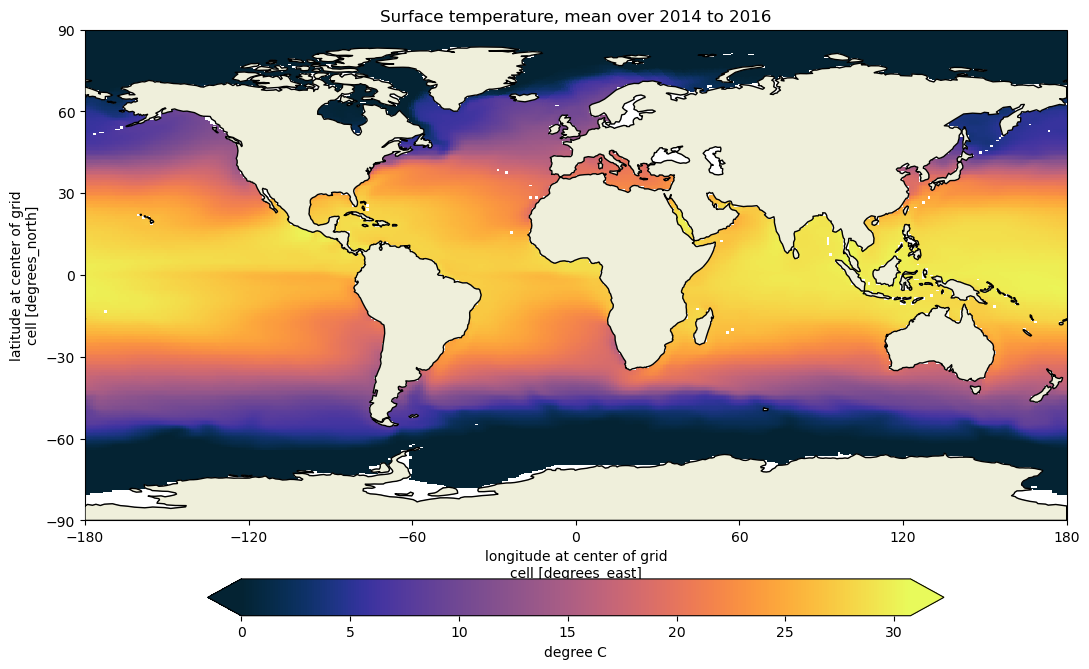

In [5]:
#Plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(subset_theta).plot(vmin=0,cmap=cmocean.cm.thermal,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "degree C"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface temperature, mean over 2014 to 2016')
fig.tight_layout()

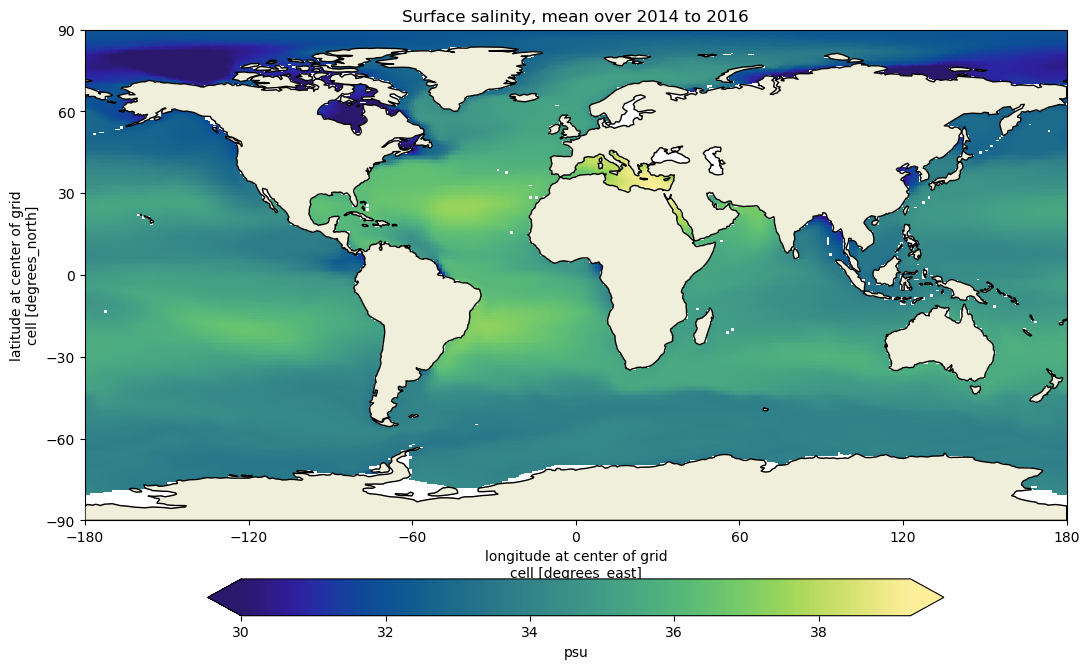

In [6]:
#Plot Sea Surface Salinity 
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(subset_salt).plot(cmap=cmocean.cm.haline,vmin=30,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "psu"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface salinity, mean over 2014 to 2016')
fig.tight_layout()

***
## Density from salt and temperature
The equation relating ocean water density to other water properties is called the *equation of state*. It is a non-linear function of temperature, salinity, and pressure. This can be expressed as $\rho=\rho(T,S,p)$. Here we will show two ways to calculate the density. The first is a *linear approximation* to the equation of state. We will then show how to calculate the full, non-linear equation of state using the *gsw* package

### Linearized equation of state
Here we take the linearized equation of state from equation 1.57 in Vallis' textbook "*Atmospheric and Oceanic Fluid Dynamics*"

$$ \rho=\rho_0[1-\beta_T(T-T_0)+\beta_S(S-S_0)+\beta_p(p-p_0)] $$

In this equation, $\rho_0\simeq 1027$ is a reference density, $\beta_T \simeq 2*10^{-4}$/K is the thermal expansion coefficient, $\beta_S \simeq 7.6*10^{-4}$/ppt is the haline contraction coefficient, and $\beta_p \simeq 4.4*10^{-10}$/Pa is the compressibility coefficient. The values with $_0$ are reference values, and here we use $T_0=283$K and $S_0=35$. Since surface pressure rarely changes by more than a few percent, let's assume that the pressure at the surface is equal to the reference pressure at every point ($\beta_p(p-p_0)=0$).

The non-linearities in the full equation of state (which we will use later) arise because, in reality, the $\beta$ terms themselves vary with pressure, salinity, and temperature.
notice we are using the theta and salt datasets, so our result will also be a dataset

In [7]:
rho=1027*(1-2E-4*(subset_theta+273.15-283)+7.6E-4*(subset_salt-35)) # basic mathemtical operations
rho

<xarray.DataArray (latitude: 360, longitude: 720)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [1027.0871889 , 1027.0871889 , 1027.0871889 , ..., 1027.0871889 ,
        1027.0871889 , 1027.0871889 ],
       [1027.11507147, 1027.11507147, 1027.11507147, ..., 1027.11507147,
        1027.11507147, 1027.11507147],
       [1027.17755495, 1027.17755495, 1027.17755495, ..., 1027.17755495,
        1027.17755495, 1027.17755495]])
Coordinates:
    i          (longitude) int64 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
    k          int64 0
    j          (latitude) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 -5.0

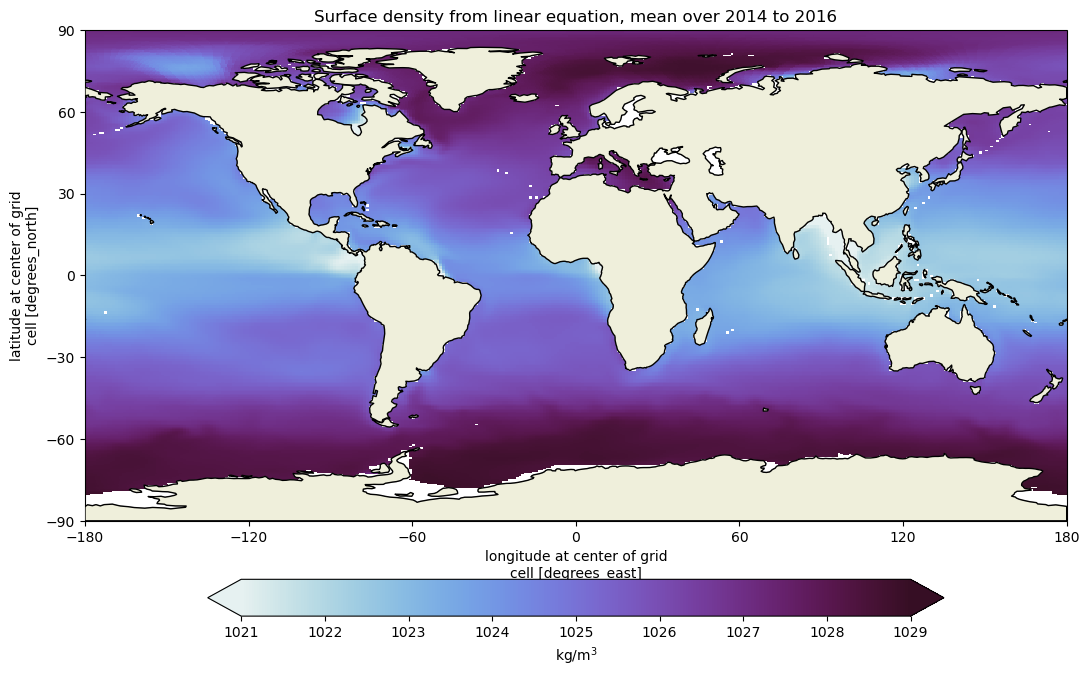

In [8]:
#Plot linearized density
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(rho).plot(cmap=cmocean.cm.dense,vmin=1021, vmax=1029, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface density from linear equation, mean over 2014 to 2016')
fig.tight_layout()

### Full nonlinear equation of state
One way to compute the density from the full nonlinear equation in python is using the *gsw* package which is a Python implementation of the *Thermodynamic Equation of Seawater 2010 (TEOS-10)* (https://teos-10.github.io/GSW-Python/)

In [9]:
CT = gsw.CT_from_pt(subset_salt,subset_theta) #get conservative temperature from potential temperature
rho_nonlin=gsw.rho(subset_salt,CT,0)

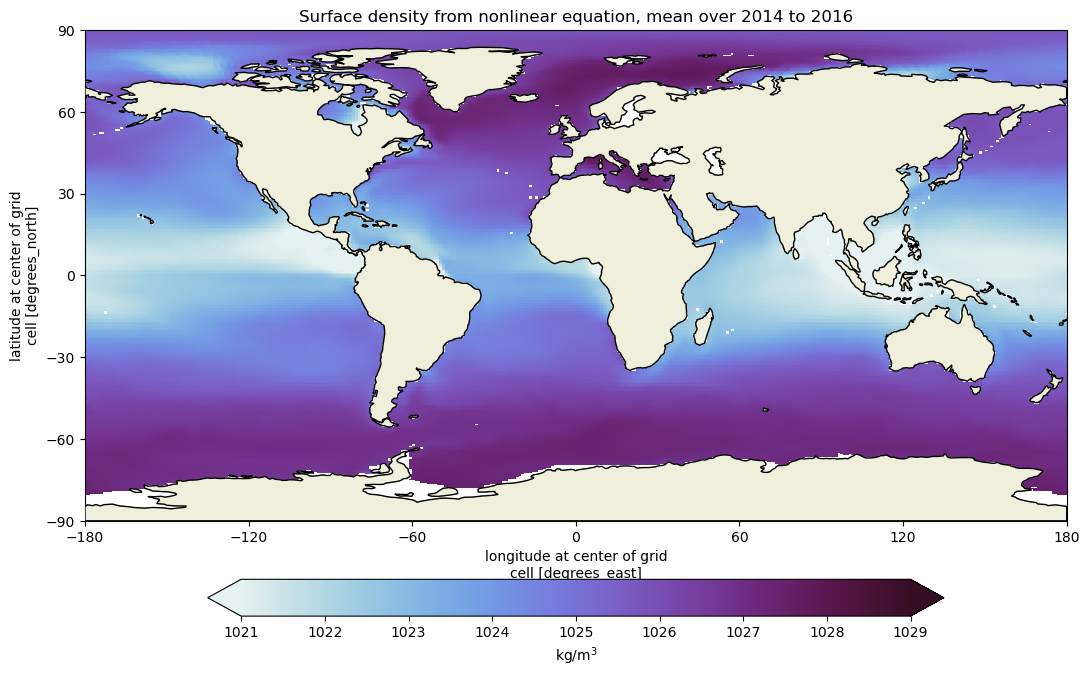

In [10]:
#Plot density from full nonlinear equation
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(rho_nonlin).plot(cmap=cmocean.cm.dense,vmin=1021, vmax=1029, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Surface density from nonlinear equation, mean over 2014 to 2016')
fig.tight_layout()

We see that the two equations of state are broadly similar but there are some differences. These differences are caused by the nonlinearity in the equation of state, where the haline contraction coefficient and thermal expansion coefficient are not constants, in contrast to our linear equation of state assumptions! 

Regardless of how we calculate the density, we see that there are horizontal density differences (gradients) at the surface of the ocean. For example, the seawater tends to be lighter in the subtropics and denser near the poles. These density differences can drive currents, as we discussed in the slides! 

suggetsion for a question from Ohad: 
can you compare those datasets (linear and nonlinear solutions) and plot the difference? 
